## Import Libraries

In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold

### 모델 학습 graph 

In [2]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [3]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

## Train

In [4]:
with open('./pickle/data.npy', 'rb') as f:
    X_trains= np.load(f)
    y_trains = np.load(f)
    TEST = np.load(f)

In [5]:
print(X_trains.shape)
print(y_trains.shape)
print(TEST.shape)

(2048, 28, 28, 3)
(2048, 10)
(20480, 28, 28, 3)


In [6]:
X_trains = X_trains.astype('float32') / 255.
TEST = TEST.astype('float32') / 255.

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential, constraints, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SeparableConv2D, Input, Conv2D, Add, BatchNormalization, concatenate, AveragePooling2D, add, MaxPooling2D 
from tensorflow.keras.layers import Conv2DTranspose, Activation, Dropout,UpSampling2D ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [12]:
reduction_ratio=16

### RexNet

In [41]:
def Xception(input_shape=(28, 28, 3)):
    # 28x28x3
    inputs = Input(input_shape)
    
    # 28x28x32
    x = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # 28x28x64
    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # 28x28x128
    residual = layers.Conv2D(128, (1, 1), padding='same', use_bias=False)(x)
    residual = layers.BatchNormalization()(residual)
    # 28x28x128
    x = layers.SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    # 28x28x128
    x = layers.add([x, residual])
    # 14x14x256
    residual = layers.Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = layers.BatchNormalization()(residual)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(56, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    # 14x14x256
    x = layers.MaxPooling2D((3, 3),strides=(2, 2),padding='same')(x)
    x = layers.add([x, residual])
    # 7x7x728
    residual = layers.Conv2D(728, (1, 1),strides=(2, 2), padding='same', use_bias=False)(x)
    residual = layers.BatchNormalization()(residual)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    # 7x7x728
    x = layers.MaxPooling2D((3, 3),strides=(2, 2),padding='same')(x)
    x = layers.add([x, residual])

    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, (3, 3),padding='same',use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, (3, 3),padding='same',use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, (3, 3),padding='same',use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        x = layers.add([x, residual])
    
    # 1x1x1024
    residual = layers.Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = layers.BatchNormalization()(residual)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    # 1x1x1024
    x = layers.MaxPooling2D((3, 3),strides=(2, 2),padding='same')(x)
    x = layers.add([x, residual])
    x = tf.keras.layers.MaxPool2D((2,2))(x) 
    
    x = layers.Flatten()(x)
    x = layers.Dense(2048, activation='elu', kernel_initializer='he_normal', kernel_constraint=constraints.max_norm(3.))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=constraints.max_norm(3.))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10 ,activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [42]:
model = Xception()

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 28, 28, 32)   864         input_20[0][0]                   
__________________________________________________________________________________________________
batch_normalization_630 (BatchN (None, 28, 28, 32)   128         conv2d_106[0][0]                 
__________________________________________________________________________________________________
activation_542 (Activation)     (None, 28, 28, 32)   0           batch_normalization_630[0][0]    
___________________________________________________________________________________________

In [43]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [44]:
# 많은 데이터 셋으로 학습시키기 위해 FOLD를 100으로 설정했습니다. Fold 1 중간에 Stop시켰기에 break 조건을 넣어놨습니다.
def get_stacking(in_model, train, train_y, n_fold = 10, SEED=2020):
    k_fold = KFold(n_splits=8, shuffle=True, random_state=SEED)
    
    epochs = 500
    model_number = 0
    history = []
    batch_size = 32
    val_predict = []

    train_fold_predict = np.zeros((train.shape[0], 1))
    test_predict = []
    arm_test_predict = np.array([0]*204800).reshape(20480, 10).astype('float64')
    
    for cnt, (train_idx, val_idx) in enumerate(k_fold.split(train, train_y)):
        print(f'*******************number_{cnt+1}_kfold_model*******************')
        x_train, y_train = train[train_idx], train_y[train_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=AdamW(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=15, verbose=1)
        mc = ModelCheckpoint(f'./model/model1_best_{model_number}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.8, min_lr=0.0001)
        
        history = model.fit(datagen.flow(x_train, y_train, shuffle=True, batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_val, y_val),
                                  verbose=1,
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  validation_steps=x_val.shape[0] // batch_size,
                                  callbacks=[es, mc, rlp]
                                  )
        
#         history = model.fit(x_train, y_train, epochs = 53, validation_data=(x_val, y_val), verbose=1, batch_size = batch_size, callbacks = [es, mc, rlp])
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        
        model.load_weights(f'./model/model1_best_{model_number}.h5')
        pred_train = model.predict(x_val)
        pred_test = model.predict(TEST)
        
        train_fold_predict[val_idx, :] = np.argmax(pred_train, 1).reshape((x_val.shape[0], 1))
        
        test_predict.append(pred_test)
    
    for pred_test in test_predict:
        arm_test_predict += pred_test
          
    test_fold_predict = np.argmax(arm_test_predict, axis=1).reshape((TEST.shape[0], 1))
    train_fold_predict = train_fold_predict.astype('int64')
    
    return train_fold_predict, test_fold_predict

## Predict

*******************number_1_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 12.0974 - accuracy: 0.1021
Epoch 00001: val_loss improved from inf to 2.56599, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 99ms/step - loss: 12.0974 - accuracy: 0.1021 - val_loss: 2.5660 - val_accuracy: 0.0820 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 3.5373 - accuracy: 0.0943
Epoch 00002: val_loss did not improve from 2.56599
56/56 [==============================] - 4s 79ms/step - loss: 3.5373 - accuracy: 0.0943 - val_loss: 2.6413 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 3.2557 - accuracy: 0.0932
Epoch 00003: val_loss did not improve from 2.56599
56/56 [==============================] - 5s 89ms/step - loss: 3.2557 - accuracy: 0.0932 - val_loss: 2.5846 - val_accuracy: 0.0781 - lr: 0.0010
Epoch 4/500
56/56 [===========

Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 2.1270 - accuracy: 0.2461
Epoch 00028: val_loss did not improve from 1.77243
56/56 [==============================] - 5s 93ms/step - loss: 2.1270 - accuracy: 0.2461 - val_loss: 1.9174 - val_accuracy: 0.2656 - lr: 6.4000e-04
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 2.1646 - accuracy: 0.2422
Epoch 00029: val_loss improved from 1.77243 to 1.76062, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 109ms/step - loss: 2.1646 - accuracy: 0.2422 - val_loss: 1.7606 - val_accuracy: 0.3164 - lr: 6.4000e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 2.0606 - accuracy: 0.2612
Epoch 00030: val_loss did not improve from 1.76062
56/56 [==============================] - 5s 92ms/step - loss: 2.0606 - accuracy: 0.2612 - val_loss: 2.0665 - val_accuracy: 0.3477 - lr: 6.4000e-04
Epoch 31/500
56/56 [==============================] - ETA: 0s - loss: 2

56/56 [==============================] - 6s 107ms/step - loss: 1.1147 - accuracy: 0.6306 - val_loss: 0.9260 - val_accuracy: 0.7109 - lr: 3.2768e-04
Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.0892 - accuracy: 0.6423
Epoch 00055: val_loss did not improve from 0.92597
56/56 [==============================] - 5s 93ms/step - loss: 1.0892 - accuracy: 0.6423 - val_loss: 1.3268 - val_accuracy: 0.5898 - lr: 3.2768e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.0403 - accuracy: 0.6546
Epoch 00056: val_loss did not improve from 0.92597
56/56 [==============================] - 5s 93ms/step - loss: 1.0403 - accuracy: 0.6546 - val_loss: 1.0029 - val_accuracy: 0.6836 - lr: 3.2768e-04
Epoch 57/500
56/56 [==============================] - ETA: 0s - loss: 0.9856 - accuracy: 0.6808
Epoch 00057: val_loss did not improve from 0.92597
56/56 [==============================] - 5s 96ms/step - loss: 0.9856 - accuracy: 0.6808 - val_loss: 1.6313 - val_accu

Epoch 82/500
56/56 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.7891
Epoch 00082: val_loss did not improve from 0.62449
56/56 [==============================] - 4s 79ms/step - loss: 0.6283 - accuracy: 0.7891 - val_loss: 0.7438 - val_accuracy: 0.7930 - lr: 1.0737e-04
Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 0.6041 - accuracy: 0.7997
Epoch 00083: val_loss did not improve from 0.62449
56/56 [==============================] - 4s 79ms/step - loss: 0.6041 - accuracy: 0.7997 - val_loss: 0.7518 - val_accuracy: 0.8086 - lr: 1.0737e-04
Epoch 84/500
56/56 [==============================] - ETA: 0s - loss: 0.6369 - accuracy: 0.7935
Epoch 00084: val_loss did not improve from 0.62449
56/56 [==============================] - 4s 79ms/step - loss: 0.6369 - accuracy: 0.7935 - val_loss: 0.7098 - val_accuracy: 0.8086 - lr: 1.0737e-04
Epoch 85/500
56/56 [==============================] - ETA: 0s - loss: 0.6197 - accuracy: 0.7935
Epoch 00085: val_loss 

Epoch 110/500
56/56 [==============================] - ETA: 0s - loss: 0.5218 - accuracy: 0.8153
Epoch 00110: val_loss did not improve from 0.61268
56/56 [==============================] - 5s 82ms/step - loss: 0.5218 - accuracy: 0.8153 - val_loss: 0.7295 - val_accuracy: 0.7891 - lr: 1.0000e-04
Epoch 111/500
56/56 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.8326
Epoch 00111: val_loss did not improve from 0.61268
56/56 [==============================] - 5s 82ms/step - loss: 0.4795 - accuracy: 0.8326 - val_loss: 0.8426 - val_accuracy: 0.7852 - lr: 1.0000e-04
Epoch 112/500
56/56 [==============================] - ETA: 0s - loss: 0.4734 - accuracy: 0.8410
Epoch 00112: val_loss did not improve from 0.61268
56/56 [==============================] - 5s 82ms/step - loss: 0.4734 - accuracy: 0.8410 - val_loss: 0.6418 - val_accuracy: 0.8164 - lr: 1.0000e-04
Epoch 113/500
56/56 [==============================] - ETA: 0s - loss: 0.4794 - accuracy: 0.8438
Epoch 00113: val_l

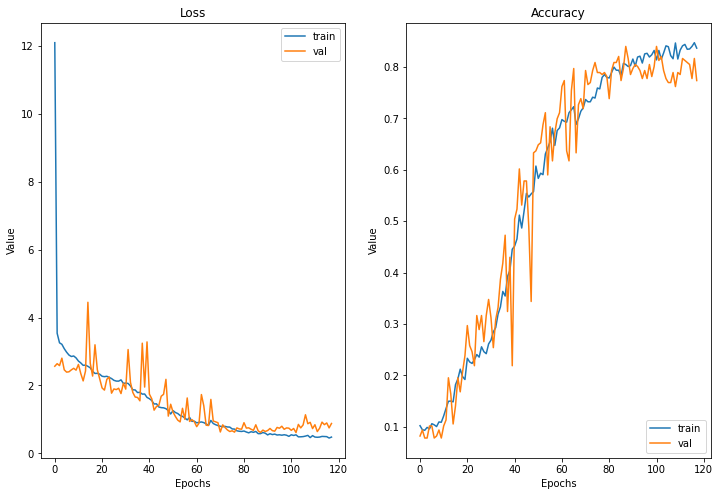

*******************number_2_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 12.7676 - accuracy: 0.1021
Epoch 00001: val_loss improved from inf to 4.88826, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 103ms/step - loss: 12.7676 - accuracy: 0.1021 - val_loss: 4.8883 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 3.5584 - accuracy: 0.0982
Epoch 00002: val_loss improved from 4.88826 to 2.91358, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 100ms/step - loss: 3.5584 - accuracy: 0.0982 - val_loss: 2.9136 - val_accuracy: 0.1094 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 3.3474 - accuracy: 0.1055
Epoch 00003: val_loss improved from 2.91358 to 2.55561, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 5s 96ms/step - loss: 3.3474 - accuracy

Epoch 27/500
56/56 [==============================] - ETA: 0s - loss: 2.3214 - accuracy: 0.1942
Epoch 00027: val_loss did not improve from 1.86645
56/56 [==============================] - 4s 80ms/step - loss: 2.3214 - accuracy: 0.1942 - val_loss: 2.0313 - val_accuracy: 0.2266 - lr: 0.0010
Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 2.2426 - accuracy: 0.2087
Epoch 00028: val_loss improved from 1.86645 to 1.76003, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 5s 93ms/step - loss: 2.2426 - accuracy: 0.2087 - val_loss: 1.7600 - val_accuracy: 0.3320 - lr: 0.0010
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 2.2387 - accuracy: 0.2215
Epoch 00029: val_loss did not improve from 1.76003
56/56 [==============================] - 4s 79ms/step - loss: 2.2387 - accuracy: 0.2215 - val_loss: 3.9460 - val_accuracy: 0.1211 - lr: 0.0010
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 2.2489 - accur

Epoch 54/500
56/56 [==============================] - ETA: 0s - loss: 1.5432 - accuracy: 0.4570
Epoch 00054: val_loss did not improve from 1.26367
56/56 [==============================] - 5s 82ms/step - loss: 1.5432 - accuracy: 0.4570 - val_loss: 1.3449 - val_accuracy: 0.5156 - lr: 5.1200e-04
Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.4942 - accuracy: 0.4866
Epoch 00055: val_loss improved from 1.26367 to 1.23568, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 5s 92ms/step - loss: 1.4942 - accuracy: 0.4866 - val_loss: 1.2357 - val_accuracy: 0.5859 - lr: 5.1200e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.4685 - accuracy: 0.4978
Epoch 00056: val_loss did not improve from 1.23568
56/56 [==============================] - 5s 81ms/step - loss: 1.4685 - accuracy: 0.4978 - val_loss: 1.5054 - val_accuracy: 0.4883 - lr: 5.1200e-04
Epoch 57/500
56/56 [==============================] - ETA: 0s - loss: 1.

Epoch 81/500
56/56 [==============================] - ETA: 0s - loss: 0.7785 - accuracy: 0.7506
Epoch 00081: val_loss improved from 0.70008 to 0.64215, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 5s 96ms/step - loss: 0.7785 - accuracy: 0.7506 - val_loss: 0.6421 - val_accuracy: 0.7891 - lr: 2.6214e-04
Epoch 82/500
56/56 [==============================] - ETA: 0s - loss: 0.7482 - accuracy: 0.7612
Epoch 00082: val_loss improved from 0.64215 to 0.60281, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 5s 92ms/step - loss: 0.7482 - accuracy: 0.7612 - val_loss: 0.6028 - val_accuracy: 0.8164 - lr: 2.6214e-04
Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 0.8265 - accuracy: 0.7394
Epoch 00083: val_loss improved from 0.60281 to 0.57986, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 5s 95ms/step - loss: 0.8265 - accuracy: 0.7394 - val_loss: 0.5799 - val_accuracy: 0.81

56/56 [==============================] - ETA: 0s - loss: 0.5234 - accuracy: 0.8354
Epoch 00108: val_loss did not improve from 0.44820
56/56 [==============================] - 5s 93ms/step - loss: 0.5234 - accuracy: 0.8354 - val_loss: 0.5274 - val_accuracy: 0.8633 - lr: 1.0737e-04
Epoch 109/500
56/56 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.8398
Epoch 00109: val_loss did not improve from 0.44820
56/56 [==============================] - 5s 81ms/step - loss: 0.5077 - accuracy: 0.8398 - val_loss: 0.5229 - val_accuracy: 0.8477 - lr: 1.0000e-04
Epoch 110/500
56/56 [==============================] - ETA: 0s - loss: 0.4854 - accuracy: 0.8354
Epoch 00110: val_loss did not improve from 0.44820
56/56 [==============================] - 4s 79ms/step - loss: 0.4854 - accuracy: 0.8354 - val_loss: 0.5600 - val_accuracy: 0.8477 - lr: 1.0000e-04
Epoch 111/500
56/56 [==============================] - ETA: 0s - loss: 0.4548 - accuracy: 0.8482
Epoch 00111: val_loss did not im

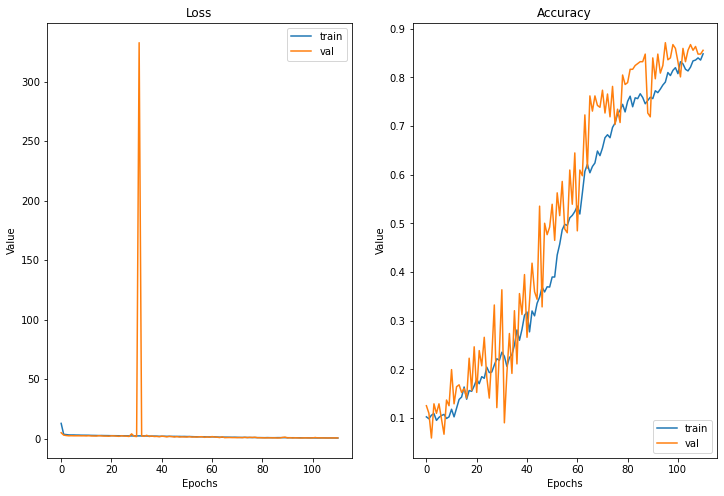

*******************number_3_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 10.6580 - accuracy: 0.1049
Epoch 00001: val_loss improved from inf to 2.86399, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 100ms/step - loss: 10.6580 - accuracy: 0.1049 - val_loss: 2.8640 - val_accuracy: 0.1133 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 3.5346 - accuracy: 0.1071
Epoch 00002: val_loss improved from 2.86399 to 2.84115, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 5s 92ms/step - loss: 3.5346 - accuracy: 0.1071 - val_loss: 2.8412 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 3.2527 - accuracy: 0.1044
Epoch 00003: val_loss improved from 2.84115 to 2.61707, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 5s 91ms/step - loss: 3.2527 - accuracy:

Epoch 27/500
56/56 [==============================] - ETA: 0s - loss: 2.2410 - accuracy: 0.2160
Epoch 00027: val_loss improved from 1.91219 to 1.83241, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 105ms/step - loss: 2.2410 - accuracy: 0.2160 - val_loss: 1.8324 - val_accuracy: 0.2773 - lr: 8.0000e-04
Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 2.2309 - accuracy: 0.2054
Epoch 00028: val_loss did not improve from 1.83241
56/56 [==============================] - 4s 80ms/step - loss: 2.2309 - accuracy: 0.2054 - val_loss: 1.9301 - val_accuracy: 0.2734 - lr: 8.0000e-04
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 2.2668 - accuracy: 0.2054
Epoch 00029: val_loss improved from 1.83241 to 1.82285, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 5s 92ms/step - loss: 2.2668 - accuracy: 0.2054 - val_loss: 1.8229 - val_accuracy: 0.3008 - lr: 8.0000e-04
Epoch 30/500
56/56 [=====

Epoch 54/500
56/56 [==============================] - ETA: 0s - loss: 1.4898 - accuracy: 0.4989
Epoch 00054: val_loss improved from 1.16780 to 0.91199, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 5s 92ms/step - loss: 1.4898 - accuracy: 0.4989 - val_loss: 0.9120 - val_accuracy: 0.7109 - lr: 5.1200e-04
Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.4059 - accuracy: 0.5206
Epoch 00055: val_loss did not improve from 0.91199
56/56 [==============================] - 4s 79ms/step - loss: 1.4059 - accuracy: 0.5206 - val_loss: 1.0818 - val_accuracy: 0.6797 - lr: 5.1200e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.3837 - accuracy: 0.5379
Epoch 00056: val_loss did not improve from 0.91199
56/56 [==============================] - 4s 79ms/step - loss: 1.3837 - accuracy: 0.5379 - val_loss: 2.4022 - val_accuracy: 0.5312 - lr: 5.1200e-04
Epoch 57/500
56/56 [==============================] - ETA: 0s - loss: 1.

56/56 [==============================] - ETA: 0s - loss: 0.7857 - accuracy: 0.7528
Epoch 00081: val_loss did not improve from 0.52147
56/56 [==============================] - 5s 83ms/step - loss: 0.7857 - accuracy: 0.7528 - val_loss: 0.7451 - val_accuracy: 0.7969 - lr: 2.6214e-04
Epoch 82/500
56/56 [==============================] - ETA: 0s - loss: 0.7726 - accuracy: 0.7511
Epoch 00082: val_loss did not improve from 0.52147
56/56 [==============================] - 4s 80ms/step - loss: 0.7726 - accuracy: 0.7511 - val_loss: 0.8166 - val_accuracy: 0.7812 - lr: 2.6214e-04
Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 0.7262 - accuracy: 0.7706
Epoch 00083: val_loss did not improve from 0.52147
56/56 [==============================] - 4s 79ms/step - loss: 0.7262 - accuracy: 0.7706 - val_loss: 0.5509 - val_accuracy: 0.8359 - lr: 2.0972e-04
Epoch 84/500
56/56 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.7612
Epoch 00084: val_loss did not impro

Epoch 109/500
56/56 [==============================] - ETA: 0s - loss: 0.4209 - accuracy: 0.8705
Epoch 00109: val_loss did not improve from 0.44385
56/56 [==============================] - 5s 91ms/step - loss: 0.4209 - accuracy: 0.8705 - val_loss: 0.5072 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 110/500
56/56 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.8616
Epoch 00110: val_loss did not improve from 0.44385
56/56 [==============================] - 5s 92ms/step - loss: 0.4486 - accuracy: 0.8616 - val_loss: 0.4686 - val_accuracy: 0.8672 - lr: 1.0000e-04
Epoch 111/500
56/56 [==============================] - ETA: 0s - loss: 0.4560 - accuracy: 0.8521
Epoch 00111: val_loss did not improve from 0.44385
56/56 [==============================] - 5s 92ms/step - loss: 0.4560 - accuracy: 0.8521 - val_loss: 0.6545 - val_accuracy: 0.8516 - lr: 1.0000e-04
Epoch 112/500
56/56 [==============================] - ETA: 0s - loss: 0.4815 - accuracy: 0.8538
Epoch 00112: val_l

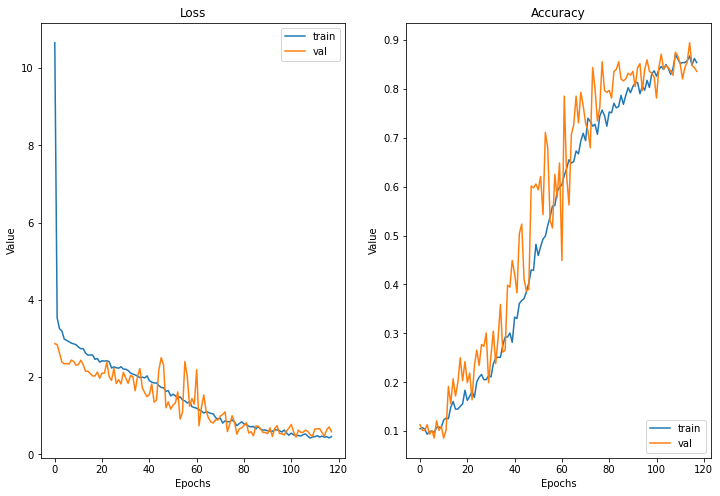

*******************number_4_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 11.6706 - accuracy: 0.1127
Epoch 00001: val_loss improved from inf to 3.54607, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 112ms/step - loss: 11.6706 - accuracy: 0.1127 - val_loss: 3.5461 - val_accuracy: 0.0977 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 3.4820 - accuracy: 0.1021
Epoch 00002: val_loss did not improve from 3.54607
56/56 [==============================] - 5s 92ms/step - loss: 3.4820 - accuracy: 0.1021 - val_loss: 4.9674 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 3.1786 - accuracy: 0.1044
Epoch 00003: val_loss did not improve from 3.54607
56/56 [==============================] - 5s 90ms/step - loss: 3.1786 - accuracy: 0.1044 - val_loss: 3.7440 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 4/500
56/56 [==========

Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 2.0676 - accuracy: 0.2634
Epoch 00028: val_loss did not improve from 1.83312
56/56 [==============================] - 5s 93ms/step - loss: 2.0676 - accuracy: 0.2634 - val_loss: 1.8793 - val_accuracy: 0.3164 - lr: 8.0000e-04
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 2.0065 - accuracy: 0.3002
Epoch 00029: val_loss improved from 1.83312 to 1.60573, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 110ms/step - loss: 2.0065 - accuracy: 0.3002 - val_loss: 1.6057 - val_accuracy: 0.4062 - lr: 8.0000e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 2.0276 - accuracy: 0.2958
Epoch 00030: val_loss did not improve from 1.60573
56/56 [==============================] - 5s 97ms/step - loss: 2.0276 - accuracy: 0.2958 - val_loss: 2.1920 - val_accuracy: 0.3281 - lr: 8.0000e-04
Epoch 31/500
56/56 [==============================] - ETA: 0s - loss: 2

Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.0583 - accuracy: 0.6501
Epoch 00055: val_loss did not improve from 0.79986
56/56 [==============================] - 5s 91ms/step - loss: 1.0583 - accuracy: 0.6501 - val_loss: 1.1523 - val_accuracy: 0.6992 - lr: 4.0960e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.0706 - accuracy: 0.6451
Epoch 00056: val_loss did not improve from 0.79986
56/56 [==============================] - 5s 91ms/step - loss: 1.0706 - accuracy: 0.6451 - val_loss: 1.1318 - val_accuracy: 0.6250 - lr: 4.0960e-04
Epoch 57/500
56/56 [==============================] - ETA: 0s - loss: 1.0417 - accuracy: 0.6602
Epoch 00057: val_loss did not improve from 0.79986
56/56 [==============================] - 5s 92ms/step - loss: 1.0417 - accuracy: 0.6602 - val_loss: 1.5732 - val_accuracy: 0.5938 - lr: 4.0960e-04
Epoch 58/500
56/56 [==============================] - ETA: 0s - loss: 1.0629 - accuracy: 0.6535
Epoch 00058: val_loss 

Epoch 82/500
56/56 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.7835
Epoch 00082: val_loss did not improve from 0.46500
56/56 [==============================] - 5s 91ms/step - loss: 0.6407 - accuracy: 0.7835 - val_loss: 0.7414 - val_accuracy: 0.7891 - lr: 2.0972e-04
Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.7902
Epoch 00083: val_loss did not improve from 0.46500
56/56 [==============================] - 5s 91ms/step - loss: 0.6598 - accuracy: 0.7902 - val_loss: 0.6180 - val_accuracy: 0.8125 - lr: 2.0972e-04
Epoch 84/500
56/56 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.7773
Epoch 00084: val_loss did not improve from 0.46500
56/56 [==============================] - 5s 91ms/step - loss: 0.6901 - accuracy: 0.7773 - val_loss: 1.2135 - val_accuracy: 0.7070 - lr: 2.0972e-04
Epoch 85/500
56/56 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.7812
Epoch 00085: val_loss 

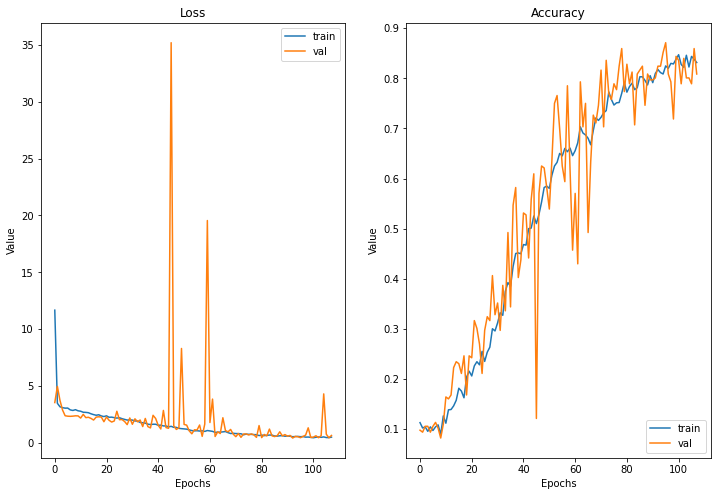

*******************number_5_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 12.2485 - accuracy: 0.1127
Epoch 00001: val_loss improved from inf to 2.74585, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 114ms/step - loss: 12.2485 - accuracy: 0.1127 - val_loss: 2.7459 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.1088
Epoch 00002: val_loss improved from 2.74585 to 2.53922, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 104ms/step - loss: 3.3883 - accuracy: 0.1088 - val_loss: 2.5392 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 3.3227 - accuracy: 0.0982
Epoch 00003: val_loss did not improve from 2.53922
56/56 [==============================] - 5s 90ms/step - loss: 3.3227 - accuracy: 0.0982 - val_loss: 2.8289 - val_accuracy: 0.

Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 2.1472 - accuracy: 0.2511
Epoch 00028: val_loss did not improve from 1.78297
56/56 [==============================] - 5s 91ms/step - loss: 2.1472 - accuracy: 0.2511 - val_loss: 2.6306 - val_accuracy: 0.2500 - lr: 5.1200e-04
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 2.1051 - accuracy: 0.2651
Epoch 00029: val_loss did not improve from 1.78297
56/56 [==============================] - 5s 92ms/step - loss: 2.1051 - accuracy: 0.2651 - val_loss: 1.8155 - val_accuracy: 0.3672 - lr: 5.1200e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 2.0703 - accuracy: 0.2600
Epoch 00030: val_loss improved from 1.78297 to 1.63376, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 105ms/step - loss: 2.0703 - accuracy: 0.2600 - val_loss: 1.6338 - val_accuracy: 0.3984 - lr: 5.1200e-04
Epoch 31/500
56/56 [==============================] - ETA: 0s - loss: 2

Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.0398 - accuracy: 0.6406
Epoch 00055: val_loss improved from 0.82278 to 0.72546, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 7s 119ms/step - loss: 1.0398 - accuracy: 0.6406 - val_loss: 0.7255 - val_accuracy: 0.7539 - lr: 2.6214e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.0267 - accuracy: 0.6574
Epoch 00056: val_loss improved from 0.72546 to 0.71534, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 106ms/step - loss: 1.0267 - accuracy: 0.6574 - val_loss: 0.7153 - val_accuracy: 0.7656 - lr: 2.6214e-04
Epoch 57/500
56/56 [==============================] - ETA: 0s - loss: 0.9573 - accuracy: 0.6747
Epoch 00057: val_loss did not improve from 0.71534
56/56 [==============================] - 5s 93ms/step - loss: 0.9573 - accuracy: 0.6747 - val_loss: 0.7402 - val_accuracy: 0.7578 - lr: 2.6214e-04
Epoch 58/500
56/56 [====

Epoch 82/500
56/56 [==============================] - ETA: 0s - loss: 0.5999 - accuracy: 0.7941
Epoch 00082: val_loss did not improve from 0.43001
56/56 [==============================] - 5s 93ms/step - loss: 0.5999 - accuracy: 0.7941 - val_loss: 0.4550 - val_accuracy: 0.8398 - lr: 1.0737e-04
Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.7913
Epoch 00083: val_loss did not improve from 0.43001
56/56 [==============================] - 5s 94ms/step - loss: 0.6327 - accuracy: 0.7913 - val_loss: 0.5436 - val_accuracy: 0.8281 - lr: 1.0737e-04
Epoch 84/500
56/56 [==============================] - ETA: 0s - loss: 0.5466 - accuracy: 0.8136
Epoch 00084: val_loss did not improve from 0.43001
56/56 [==============================] - 5s 92ms/step - loss: 0.5466 - accuracy: 0.8136 - val_loss: 0.4364 - val_accuracy: 0.8594 - lr: 1.0737e-04
Epoch 85/500
56/56 [==============================] - ETA: 0s - loss: 0.5685 - accuracy: 0.8097
Epoch 00085: val_loss 

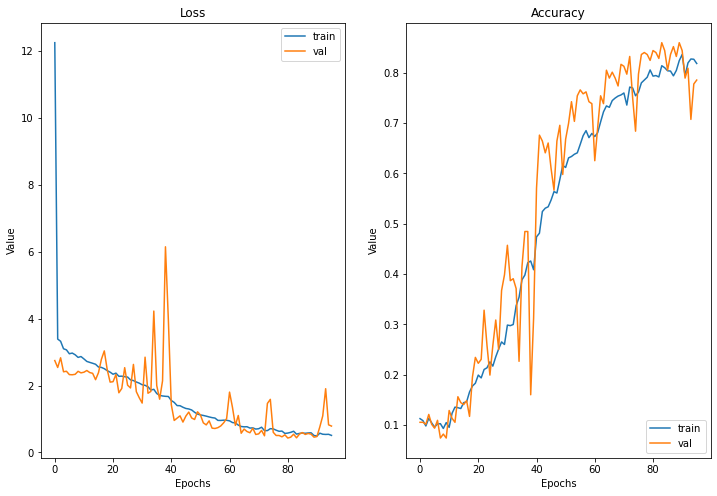

*******************number_6_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 12.1469 - accuracy: 0.0993
Epoch 00001: val_loss improved from inf to 2.67007, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 112ms/step - loss: 12.1469 - accuracy: 0.0993 - val_loss: 2.6701 - val_accuracy: 0.0859 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 3.6880 - accuracy: 0.0993
Epoch 00002: val_loss did not improve from 2.67007
56/56 [==============================] - 5s 89ms/step - loss: 3.6880 - accuracy: 0.0993 - val_loss: 2.8185 - val_accuracy: 0.0859 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 3.2580 - accuracy: 0.1032
Epoch 00003: val_loss improved from 2.67007 to 2.35093, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 5s 94ms/step - loss: 3.2580 - accuracy: 0.1032 - val_loss: 2.3509 - val_accuracy: 0.1

56/56 [==============================] - 5s 93ms/step - loss: 2.2532 - accuracy: 0.2165 - val_loss: 1.6880 - val_accuracy: 0.3672 - lr: 6.4000e-04
Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 2.2190 - accuracy: 0.2271
Epoch 00028: val_loss did not improve from 1.68802
56/56 [==============================] - 4s 80ms/step - loss: 2.2190 - accuracy: 0.2271 - val_loss: 2.4589 - val_accuracy: 0.1016 - lr: 6.4000e-04
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 2.1865 - accuracy: 0.2327
Epoch 00029: val_loss did not improve from 1.68802
56/56 [==============================] - 4s 79ms/step - loss: 2.1865 - accuracy: 0.2327 - val_loss: 2.3226 - val_accuracy: 0.2383 - lr: 6.4000e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 2.1370 - accuracy: 0.2372
Epoch 00030: val_loss did not improve from 1.68802
56/56 [==============================] - 4s 80ms/step - loss: 2.1370 - accuracy: 0.2372 - val_loss: 2.0291 - val_accur

56/56 [==============================] - 5s 95ms/step - loss: 1.5989 - accuracy: 0.4520 - val_loss: 0.9672 - val_accuracy: 0.6641 - lr: 4.0960e-04
Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.5002 - accuracy: 0.4877
Epoch 00055: val_loss did not improve from 0.96720
56/56 [==============================] - 4s 79ms/step - loss: 1.5002 - accuracy: 0.4877 - val_loss: 1.0817 - val_accuracy: 0.6797 - lr: 4.0960e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.4098 - accuracy: 0.5251
Epoch 00056: val_loss did not improve from 0.96720
56/56 [==============================] - 4s 80ms/step - loss: 1.4098 - accuracy: 0.5251 - val_loss: 1.2081 - val_accuracy: 0.6133 - lr: 4.0960e-04
Epoch 57/500
56/56 [==============================] - ETA: 0s - loss: 1.4581 - accuracy: 0.5061
Epoch 00057: val_loss did not improve from 0.96720
56/56 [==============================] - 4s 80ms/step - loss: 1.4581 - accuracy: 0.5061 - val_loss: 1.5554 - val_accur

Epoch 82/500
56/56 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.7634
Epoch 00082: val_loss did not improve from 0.62684
56/56 [==============================] - 4s 79ms/step - loss: 0.7302 - accuracy: 0.7634 - val_loss: 0.6564 - val_accuracy: 0.8242 - lr: 2.0972e-04
Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.7829
Epoch 00083: val_loss improved from 0.62684 to 0.47632, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 5s 93ms/step - loss: 0.6835 - accuracy: 0.7829 - val_loss: 0.4763 - val_accuracy: 0.8320 - lr: 1.6777e-04
Epoch 84/500
56/56 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.7863
Epoch 00084: val_loss did not improve from 0.47632
56/56 [==============================] - 4s 80ms/step - loss: 0.6912 - accuracy: 0.7863 - val_loss: 0.5453 - val_accuracy: 0.8281 - lr: 1.6777e-04
Epoch 85/500
56/56 [==============================] - ETA: 0s - loss: 0.

Epoch 110/500
56/56 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.8493
Epoch 00110: val_loss improved from 0.46510 to 0.43740, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 5s 96ms/step - loss: 0.4656 - accuracy: 0.8493 - val_loss: 0.4374 - val_accuracy: 0.8711 - lr: 1.0000e-04
Epoch 111/500
56/56 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.8398
Epoch 00111: val_loss did not improve from 0.43740
56/56 [==============================] - 4s 79ms/step - loss: 0.5045 - accuracy: 0.8398 - val_loss: 0.5412 - val_accuracy: 0.8555 - lr: 1.0000e-04
Epoch 112/500
56/56 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.8627
Epoch 00112: val_loss did not improve from 0.43740
56/56 [==============================] - 4s 80ms/step - loss: 0.4354 - accuracy: 0.8627 - val_loss: 0.6762 - val_accuracy: 0.8516 - lr: 1.0000e-04
Epoch 113/500
56/56 [==============================] - ETA: 0s - loss

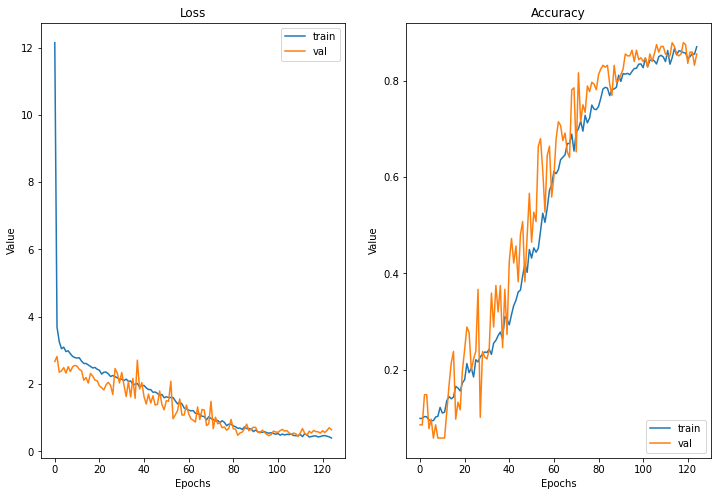

*******************number_7_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 12.6386 - accuracy: 0.0943
Epoch 00001: val_loss improved from inf to 3.19798, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 116ms/step - loss: 12.6386 - accuracy: 0.0943 - val_loss: 3.1980 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 3.3071 - accuracy: 0.0971
Epoch 00002: val_loss improved from 3.19798 to 2.72072, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 105ms/step - loss: 3.3071 - accuracy: 0.0971 - val_loss: 2.7207 - val_accuracy: 0.1133 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 3.1727 - accuracy: 0.1088
Epoch 00003: val_loss improved from 2.72072 to 2.36522, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 104ms/step - loss: 3.1727 - accurac

56/56 [==============================] - ETA: 0s - loss: 2.1962 - accuracy: 0.2360
Epoch 00027: val_loss did not improve from 1.85262
56/56 [==============================] - 5s 91ms/step - loss: 2.1962 - accuracy: 0.2360 - val_loss: 2.1629 - val_accuracy: 0.2812 - lr: 8.0000e-04
Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 2.2173 - accuracy: 0.2238
Epoch 00028: val_loss did not improve from 1.85262
56/56 [==============================] - 5s 92ms/step - loss: 2.2173 - accuracy: 0.2238 - val_loss: 2.4677 - val_accuracy: 0.1992 - lr: 8.0000e-04
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 2.2947 - accuracy: 0.1998
Epoch 00029: val_loss did not improve from 1.85262
56/56 [==============================] - 5s 92ms/step - loss: 2.2947 - accuracy: 0.1998 - val_loss: 2.2863 - val_accuracy: 0.3164 - lr: 8.0000e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 2.1372 - accuracy: 0.2243
Epoch 00030: val_loss improved from

Epoch 54/500
56/56 [==============================] - ETA: 0s - loss: 1.3629 - accuracy: 0.5391
Epoch 00054: val_loss did not improve from 0.95931
56/56 [==============================] - 5s 92ms/step - loss: 1.3629 - accuracy: 0.5391 - val_loss: 1.9561 - val_accuracy: 0.4805 - lr: 4.0960e-04
Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.3643 - accuracy: 0.5206
Epoch 00055: val_loss did not improve from 0.95931
56/56 [==============================] - 5s 92ms/step - loss: 1.3643 - accuracy: 0.5206 - val_loss: 2.2721 - val_accuracy: 0.4453 - lr: 4.0960e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.3101 - accuracy: 0.5625
Epoch 00056: val_loss did not improve from 0.95931
56/56 [==============================] - 5s 93ms/step - loss: 1.3101 - accuracy: 0.5625 - val_loss: 1.0794 - val_accuracy: 0.6719 - lr: 4.0960e-04
Epoch 57/500
56/56 [==============================] - ETA: 0s - loss: 1.2192 - accuracy: 0.5887
Epoch 00057: val_loss 

56/56 [==============================] - ETA: 0s - loss: 0.6865 - accuracy: 0.7734
Epoch 00081: val_loss improved from 0.55196 to 0.50337, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 106ms/step - loss: 0.6865 - accuracy: 0.7734 - val_loss: 0.5034 - val_accuracy: 0.8320 - lr: 1.6777e-04
Epoch 82/500
56/56 [==============================] - ETA: 0s - loss: 0.7149 - accuracy: 0.7673
Epoch 00082: val_loss did not improve from 0.50337
56/56 [==============================] - 5s 93ms/step - loss: 0.7149 - accuracy: 0.7673 - val_loss: 0.6940 - val_accuracy: 0.8047 - lr: 1.6777e-04
Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.7812
Epoch 00083: val_loss did not improve from 0.50337
56/56 [==============================] - 5s 92ms/step - loss: 0.6876 - accuracy: 0.7812 - val_loss: 0.5419 - val_accuracy: 0.8359 - lr: 1.6777e-04
Epoch 84/500
56/56 [==============================] - ETA: 0s - loss: 0.6541 - accur

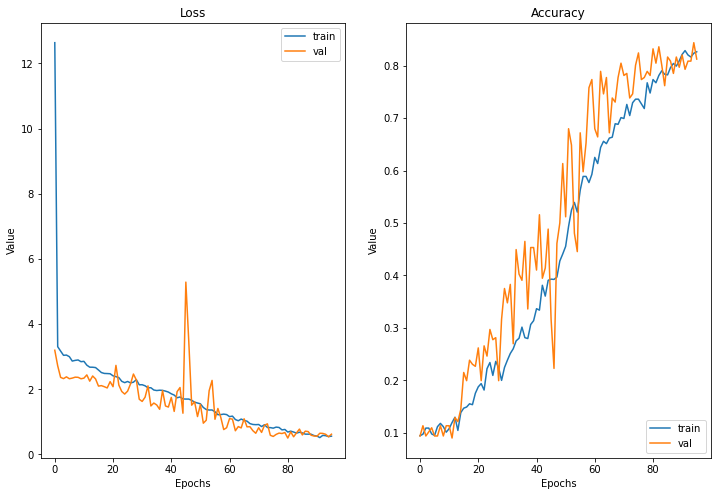

*******************number_8_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 11.6562 - accuracy: 0.1060
Epoch 00001: val_loss improved from inf to 2.70635, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 113ms/step - loss: 11.6562 - accuracy: 0.1060 - val_loss: 2.7064 - val_accuracy: 0.0586 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 3.7828 - accuracy: 0.0943
Epoch 00002: val_loss did not improve from 2.70635
56/56 [==============================] - 5s 92ms/step - loss: 3.7828 - accuracy: 0.0943 - val_loss: 2.7269 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 3.3162 - accuracy: 0.0910
Epoch 00003: val_loss improved from 2.70635 to 2.37955, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 106ms/step - loss: 3.3162 - accuracy: 0.0910 - val_loss: 2.3795 - val_accuracy: 0.

56/56 [==============================] - 6s 109ms/step - loss: 2.1916 - accuracy: 0.2282 - val_loss: 1.8964 - val_accuracy: 0.2305 - lr: 8.0000e-04
Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 2.1644 - accuracy: 0.2327
Epoch 00028: val_loss improved from 1.89638 to 1.72947, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 6s 106ms/step - loss: 2.1644 - accuracy: 0.2327 - val_loss: 1.7295 - val_accuracy: 0.3672 - lr: 8.0000e-04
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 2.1458 - accuracy: 0.2400
Epoch 00029: val_loss did not improve from 1.72947
56/56 [==============================] - 5s 93ms/step - loss: 2.1458 - accuracy: 0.2400 - val_loss: 1.9041 - val_accuracy: 0.2695 - lr: 8.0000e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 2.0956 - accuracy: 0.2522
Epoch 00030: val_loss did not improve from 1.72947
56/56 [==============================] - 5s 91ms/step - loss: 2.0956 -

Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.2773 - accuracy: 0.5725
Epoch 00055: val_loss did not improve from 0.86967
56/56 [==============================] - 5s 93ms/step - loss: 1.2773 - accuracy: 0.5725 - val_loss: 0.9239 - val_accuracy: 0.6914 - lr: 3.2768e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.1946 - accuracy: 0.6077
Epoch 00056: val_loss did not improve from 0.86967
56/56 [==============================] - 5s 92ms/step - loss: 1.1946 - accuracy: 0.6077 - val_loss: 1.3662 - val_accuracy: 0.5820 - lr: 3.2768e-04
Epoch 57/500
56/56 [==============================] - ETA: 0s - loss: 1.1528 - accuracy: 0.6088
Epoch 00057: val_loss did not improve from 0.86967
56/56 [==============================] - 5s 92ms/step - loss: 1.1528 - accuracy: 0.6088 - val_loss: 1.0167 - val_accuracy: 0.6523 - lr: 3.2768e-04
Epoch 58/500
56/56 [==============================] - ETA: 0s - loss: 1.1097 - accuracy: 0.6233
Epoch 00058: val_loss 

Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 0.6272 - accuracy: 0.7980
Epoch 00083: val_loss did not improve from 0.67303
56/56 [==============================] - 4s 80ms/step - loss: 0.6272 - accuracy: 0.7980 - val_loss: 0.7891 - val_accuracy: 0.8008 - lr: 1.0000e-04
Epoch 84/500
56/56 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.7919
Epoch 00084: val_loss did not improve from 0.67303
56/56 [==============================] - 4s 79ms/step - loss: 0.6770 - accuracy: 0.7919 - val_loss: 0.7012 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 85/500
56/56 [==============================] - ETA: 0s - loss: 0.6397 - accuracy: 0.7924
Epoch 00085: val_loss did not improve from 0.67303
56/56 [==============================] - 4s 79ms/step - loss: 0.6397 - accuracy: 0.7924 - val_loss: 0.7299 - val_accuracy: 0.7891 - lr: 1.0000e-04
Epoch 00085: early stopping


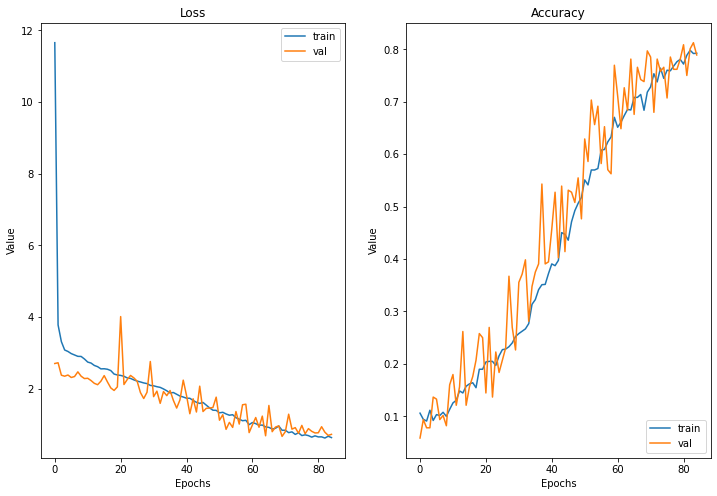

In [45]:
model_train, model_test = get_stacking(Xception, X_trains, y_trains)

## Pickle 파일 저장

In [46]:
pickle.dump(model_train, open("./new_data/{}.pkl".format('xp2_train_km'), "wb"))
pickle.dump(model_test, open("./new_data/{}.pkl".format('xp2_test_km'), "wb"))